#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Flowers Image Classification
## Exercise 3: Feature Extraction and Fine-Tuning
**_Estimated completion time: 30 minutes_**

In Exercise 1, we built a convnet from scratch, and were able to achieve an accuracy of about 70%. With the addition of data augmentation and dropout in Exercise 2, we were able to increase accuracy to about 80%. That seems decent, but 20% is still too high of an error rate. Maybe we just don't have enough training data available to properly solve the problem. What other approaches can we try?

In this exercise, we'll look at two techniques for repurposing feature data generated from image models that have already been trained on large sets of data, **feature extraction** and **fine tuning**, and use them to improve the accuracy of our cat vs. dog classification model.

## Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [ ]:
!pip2 install tensorflow keras pillow

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np

Now let's download the weights:

In [ ]:
#!wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O ./

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [3]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

('last layer output shape:', (None, 7, 7, 768))


Now let's stick a fully connected classifier on top of `last_output`:

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

For examples and data preprocessing, let's use the same files and `train_generator` as we did in Exercise 2.

Get our flowers dataset

In [ ]:
#!wget --no-check-certificate https://transfer.sh/XnpD8/Flower.zip /tmp/flower.zip

In [6]:
import os
#os.listdir("/tmp/")
os.listdir("./")
#os.rename("Flower.zip).zip","/tmp/Flower.zip")

['.DS_Store',
 '.ipynb_checkpoints',
 'Dataset',
 'Flower.zip',
 'image_classification_inceptionV3_Flowers.ipynb',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'model_colab.h5',
 'model_simple.h5',
 'model_tuned.h5']

In [7]:
os.path.getsize("./Flower.zip")

429184371

In [8]:
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# local_zip = './Flower.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./')
# zip_ref.close()

# Define our example directories and files
base_dir = 'Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


In [9]:
os.listdir(".")

['.DS_Store',
 '.ipynb_checkpoints',
 'Dataset',
 'Flower.zip',
 'image_classification_inceptionV3_Flowers.ipynb',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'model_colab.h5',
 'model_simple.h5',
 'model_tuned.h5']

In [10]:
# Directory with our training red roses
train_rose_dir = os.path.join(train_dir, 'HOA HONG DO')

# Directory with our training Xuyen Chi Flowers
train_xuyenchi_dir = os.path.join(train_dir, 'HOA XUYEN CHI')

# Directory with our validation red roses pictures
validation_rose_dir = os.path.join(validation_dir, 'HOA HONG DO')

# Directory with our validation Xhuyen Chi Flowers pictures
validation_xuyenchi_dir = os.path.join(validation_dir, 'HOA XUYEN CHI')


In [11]:
train_rose_fnames = os.listdir(validation_rose_dir)
train_xuyenchi_fnames = os.listdir(validation_xuyenchi_dir)
print(train_rose_fnames)
print(train_xuyenchi_fnames)

['HOA HONG DO_0.JPG', 'HOA HONG DO_1.JPG', 'HOA HONG DO_2.JPG', 'HOA HONG DO_3.JPG', 'HOA HONG DO_4.JPG', 'HOA HONG DO_5.JPG', 'HOA HONG DO_6.JPG', 'HOA HONG DO_7.JPG', 'HOA HONG DO_8.JPG', 'HOA HONG DO_9.JPG']
['HOA XUYEN CHI_0.JPG', 'HOA XUYEN CHI_1.JPG', 'HOA XUYEN CHI_2.JPG', 'HOA XUYEN CHI_3.JPG', 'HOA XUYEN CHI_4.JPG', 'HOA XUYEN CHI_5.JPG', 'HOA XUYEN CHI_6.JPG', 'HOA XUYEN CHI_7.JPG', 'HOA XUYEN CHI_8.JPG', 'HOA XUYEN CHI_9.JPG']


In [12]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        # class_mode='binary'
        class_mode = 'categorical'
        )
    

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        #class_mode='binary'
        class_mode = 'categorical'
        )

Found 272 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


Finally, let's train the model using the features we extracted. We'll train on all 272 images available, for 2 epochs, and validate on all 30 test images.

In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=1,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/1
 - 883s - loss: 0.2746 - acc: 0.8985 - val_loss: 0.3641 - val_acc: 0.8280


You can see that we reach a validation accuracy of 88–90% very quickly. This is much better than the small model we trained from scratch.

## Further Improving Accuracy with Fine-Tuning

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `mixed7` module—i.e., all layers found after `mixed6`—and recompile the model:

In [14]:
#model.save("simple_model.h5")
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

Now let's retrain the model. We'll train on all 2000 images available, for 50 epochs, and validate on all 1,000 test images. (This may take 15-20 minutes to run.)

In [16]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

Epoch 1/10
 - 801s - loss: 0.0578 - acc: 0.9807 - val_loss: 0.3594 - val_acc: 0.8400
Epoch 2/10
 - 788s - loss: 0.0538 - acc: 0.9827 - val_loss: 0.3268 - val_acc: 0.8600
Epoch 3/10
 - 784s - loss: 0.0532 - acc: 0.9812 - val_loss: 0.3568 - val_acc: 0.8400
Epoch 4/10
 - 780s - loss: 0.0541 - acc: 0.9847 - val_loss: 0.2642 - val_acc: 0.8800
Epoch 5/10
 - 785s - loss: 0.0480 - acc: 0.9865 - val_loss: 0.3407 - val_acc: 0.8600
Epoch 6/10
 - 785s - loss: 0.0519 - acc: 0.9820 - val_loss: 0.2829 - val_acc: 0.8600
Epoch 7/10
 - 798s - loss: 0.0544 - acc: 0.9823 - val_loss: 0.3585 - val_acc: 0.8400
Epoch 8/10
 - 789s - loss: 0.0470 - acc: 0.9842 - val_loss: 0.2941 - val_acc: 0.8600
Epoch 9/10
 - 788s - loss: 0.0457 - acc: 0.9852 - val_loss: 0.3233 - val_acc: 0.8800
Epoch 10/10
 - 775s - loss: 0.0481 - acc: 0.9832 - val_loss: 0.2932 - val_acc: 0.9000


We are seeing a nice improvement, with the validation loss going from ~1.7 down to ~1.2, and accuracy going from 88% to 92%. That's a 4.5% relative improvement in accuracy.

Let's plot the training and validation loss and accuracy to show it conclusively:

Text(0.5,1,u'Training and validation loss')

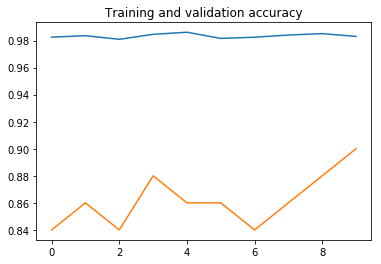

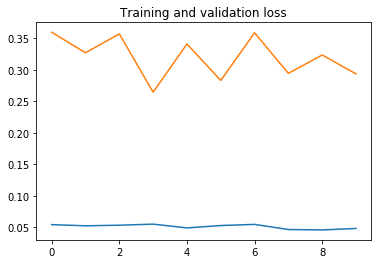

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Congratulations! Using feature extraction and fine-tuning, you've built an image classification model that can identify cats vs. dogs in images with over 90% accuracy.

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [24]:
model.save("model_tuned.h5")

In [18]:
model

In [19]:
list_of_labels = os.listdir("./Dataset/train")
list_of_labels

['HOA DAM BUT', 'HOA HONG DO', 'HOA XUYEN CHI']

In [20]:
from PIL import Image

# pick a file in HOA HONG DO
rose_file_names = os.listdir("./Dataset/validation/HOA HONG DO/")

img = Image.open("./Dataset/validation/HOA HONG DO/" + rose_file_names[0])
img_resize = img.resize((150,150))
np_image = np.array(img_resize)
np_image = np_image.reshape(1,150,150,3) * 1./255

id_predict = np.argmax(model.predict(np_image))
prediction = list_of_labels[id_predict]
print("Computer thinks this is a: {}".format(prediction))

Computer thinks this is a: HOA HONG DO


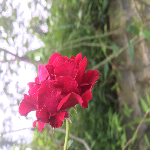

In [21]:
img_resize

In [22]:
# Make this more efficient. Let's rename the file to the name of prediction
for label in list_of_labels:
    folder_path = validation_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        img = Image.open(file_path)
        img_resize = img.resize((150,150))
        np_image = np.array(img_resize)
        np_image = np_image.reshape(1,150,150,3) * 1./255
        id_predict = np.argmax(model.predict(np_image))
        confidence = int(round(np.max(model.predict(np_image)) * 100))
        prediction = list_of_labels[id_predict]
        os.rename(file_path,folder_path + "/" + str(index) + "_" + prediction + "_" + str(confidence) + ".JPG")

In [23]:
# Make this more efficient. Let's rename the file to the name of prediction
for label in list_of_labels:
    folder_path = train_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        img = Image.open(file_path)
        img_resize = img.resize((150,150))
        np_image = np.array(img_resize)
        np_image = np_image.reshape(1,150,150,3) * 1./255
        id_predict = np.argmax(model.predict(np_image))
        confidence = int(round(np.max(model.predict(np_image)) * 100))
        prediction = list_of_labels[id_predict]
        os.rename(file_path,folder_path + "/" + str(index) + "_" + prediction + "_" + str(confidence) + ".JPG")